Scaled Feature:
 [[0.37030191 0.94545455 0.37704918]
 [0.26648182 0.81818182 0.38319672]
 [0.32008626 0.56363636 0.34221311]
 ...
 [0.58626001 0.27272727 0.26434426]
 [0.27387554 0.58181818 0.72131148]
 [0.30683919 0.47272727 1.        ]]
Standardized Feature:
 [[-0.27513316  1.76431945  0.17613061]
 [-0.82050782  1.02975149  0.21156968]
 [-0.53891972 -0.43938443 -0.02469083]
 ...
 [ 0.85931086 -2.11839691 -0.47358581]
 [-0.78166808 -0.33444615  2.16071892]
 [-0.60850758 -0.96407583  3.76729042]]


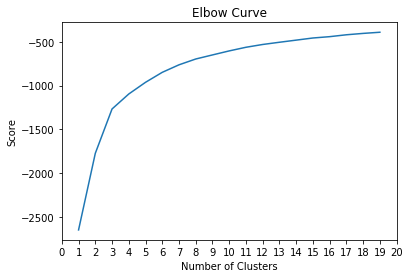

In [2]:
# Extracting weather features of interests

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

weather = pd.read_csv('weather_daily_darksky.csv')
weather_features = weather[['temperatureMax','humidity','windSpeed']]
weather_features = weather_features.dropna()
#print(weather_features.head())

# Normalizing the data to range(0,1)
scaled_feature = MinMaxScaler().fit_transform(weather_features)
print("Scaled Feature:\n {}".format(scaled_feature))

# Standadizing the data to mean=0, var=1
stand_feature = StandardScaler().fit_transform(weather_features)
print("Standardized Feature:\n {}".format(stand_feature))


# Determine # of clusters k to use for k-means

num_clusters = range(1,20)
i = 1
k_means = [KMeans(n_clusters = i) for i in num_clusters]
score = [k_means[i].fit(stand_feature).score(stand_feature) \
         for i in range(len(k_means))]
score

plt.plot(num_clusters,score)
plt.xlabel('Number of Clusters')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()


Text(0, 0.5, 'WindSpeed (m/s)')

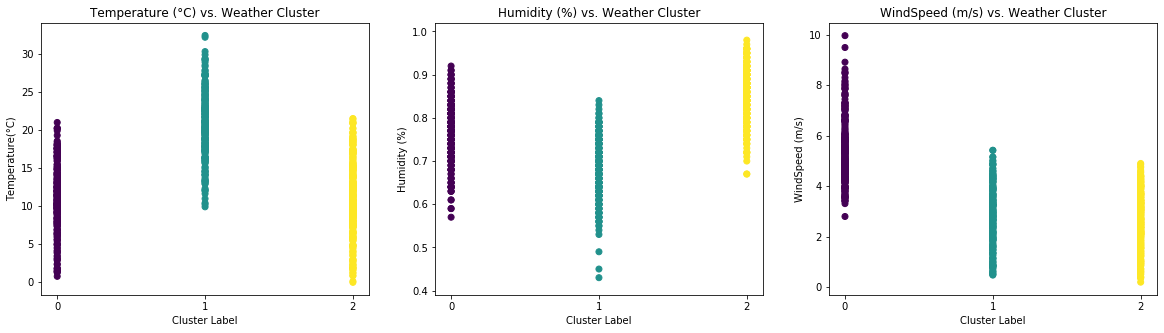

In [3]:
# from elbow curve, we draw conclusion that 3 clusters (k=3) is optimal

kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(stand_feature)
c_pred = kmeans.predict(stand_feature)
weather_features['weather_cluster'] = kmeans.labels_

# Look at feature ranges of the 3 features of interest (3 clusters each)
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title('Temperature (°C) vs. Weather Cluster')
plt.scatter(weather_features.weather_cluster, weather_features.temperatureMax, c= c_pred)
plt.xticks([0,1,2])
plt.xlabel('Cluster Label')
plt.ylabel('Temperature(°C)')

plt.subplot(1,3,2)
plt.title('Humidity (%) vs. Weather Cluster')
plt.scatter(weather_features.weather_cluster, weather_features.humidity, c= c_pred)
plt.xticks([0,1,2])
plt.xlabel('Cluster Label')
plt.ylabel('Humidity (%)')

plt.subplot(1,3,3)
plt.title('WindSpeed (m/s) vs. Weather Cluster')
plt.scatter(weather_features.weather_cluster, weather_features.windSpeed, c= c_pred)
plt.xticks([0,1,2])
plt.xlabel('Cluster Label')
plt.ylabel('WindSpeed (m/s)')

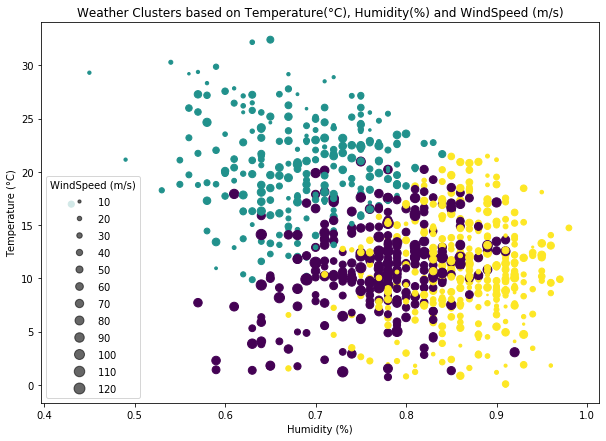

In [4]:
fig, ax1 = plt.subplots(figsize = (10,7))
kmeansplt= ax1.scatter(weather_features.humidity,weather_features.temperatureMax, 
            s = weather_features.windSpeed*13,
            c = weather_features.weather_cluster)
ax1.set_xlabel('Humidity (%)')
ax1.set_ylabel('Temperature (°C)')

plt.title('Weather Clusters based on Temperature(°C), Humidity(%) and WindSpeed (m/s)')

handles, labels = kmeansplt.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax1.legend(handles, labels, loc="lower left", title="WindSpeed (m/s)")

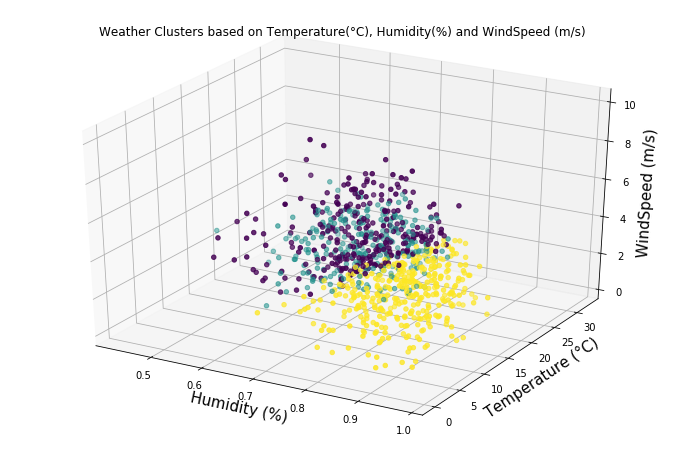

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#Plot Polynomial Kernel Characterization Result
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111, projection='3d')

x1 = list(weather_features.humidity)
x2 = list(weather_features.temperatureMax)
x3 = list(weather_features.windSpeed)

plt.title('Weather Clusters based on Temperature(°C), Humidity(%) and WindSpeed (m/s)')
ax.scatter(x1, x2, x3, c=c_pred, marker='o')

ax.set_xlabel('Humidity (%)',fontsize = 15)
ax.set_ylabel('Temperature (°C)',fontsize = 15)
ax.set_zlabel('WindSpeed (m/s)',fontsize = 15)

plt.show()

In [6]:
for num in range(0,112):
    df = pd.read_csv("daily_dataset/daily_dataset/block_"+str(num)+".csv")
    df = df[['day','LCLid','energy_sum']]
    df.reset_index()
    df.to_csv("hc_"+str(num)+".csv")

fout= open("energy.csv","a")
# first file:
for line in open("hc_0.csv"):
    fout.write(line)
# now the rest:    
for num in range(0,112):
    f = open("hc_"+str(num)+".csv")
    f.readline() # skip the header
    for line in f:
         fout.write(line)
    f.close()
fout.close()

In [7]:
# Extracting day value from timestamp in the weather data
#weather = pd.read_csv('weather_daily_darksky.csv')

#weather['day']=  pd.to_datetime(weather['time']) 
#weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date


In [8]:
energy = pd.read_csv('energy.csv', low_memory=False)
len(energy)

# count how many household we collect energy consumption data of each day
housecount = energy.groupby('day')[['LCLid']].nunique()
housecount.head(4)

# This plot shows the changes in household that adopted smart meter
#housecount.plot(figsize=(25,5))

# Calculate daily energy consumption for given household count on that day
energy = energy.groupby('day')[['energy_sum']].sum()
energy = energy.merge(housecount, on = ['day'])
energy = energy.reset_index()

energy.day = pd.to_datetime(energy.day,format='%Y-%m-%d').dt.date
energy['avg_energy'] =  energy['energy_sum']/energy['LCLid']

energy.describe()

,energy_sum,LCLid,avg_energy
count,829.000000,829.000000,829.000000
mean,43535.325676,4234.539204,10.491862
std,20550.594031,1789.994799,1.902513
min,90.385000,13.000000,0.211766
25%,34665.436003,4084.000000,8.676955
50%,46641.160997,5138.000000,10.516983
75%,59755.616996,5369.000000,12.000690
max,84156.135002,5541.000000,15.964434


In [9]:
import numpy as np

# Extracting day value from timestamp in the weather data
weather = pd.read_csv('weather_daily_darksky.csv')

weather['day']=  pd.to_datetime(weather['time']) 
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date
weather['weather_cluster'] = kmeans.labels_

weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day','weather_cluster']]
weather = weather.dropna()

# Merge energy table (with LCLid, avg_energy/household and daily energy sum) with the weather data
weather_energy =  energy.merge(weather,on='day')


# Read in the bank holidays, make indicator column that indicates whether a given day is a bank holiday
#holiday = pd.read_csv('uk_bank_holidays.csv')
#holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays'],format='%Y-%m-%d').dt.date

#weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
#weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

weather_energy['Year'] = pd.DatetimeIndex(weather_energy['day']).year  
weather_energy['Month'] = pd.DatetimeIndex(weather_energy['day']).month
weather_energy.set_index(['day'],inplace=True)

weather_energy.head(2)

,energy_sum,LCLid,avg_energy,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,...,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,weather_cluster,Year,Month
day,,,,,,,,,,,,,,,,,,,,,
2011-11-23,90.385,13,6.952692,10.36,229,6.29,0.36,2.04,1027.12,10.36,...,10.36,1.0,8.24,3.81,10.36,2.18,0.94,2,2011,11
2011-11-24,213.412,25,8.536480,12.93,204,8.56,0.41,4.04,1027.22,12.93,...,12.93,1.0,9.71,8.56,12.93,7.01,0.97,2,2011,11


In [10]:
model_data = weather_energy[['avg_energy','weather_cluster']]
model_data.head(4)

,avg_energy,weather_cluster
day,,
2011-11-23,6.952692,2
2011-11-24,8.536480,2
2011-11-25,9.499781,0
2011-11-26,10.267707,0


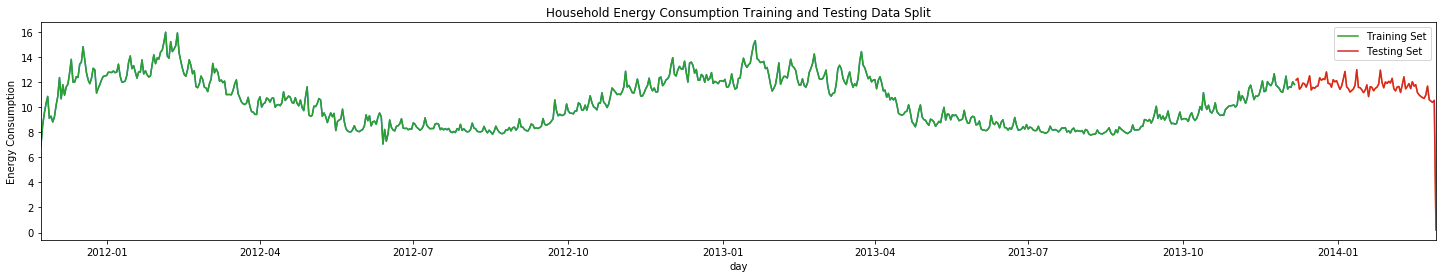

In [11]:
# print(len(model_data)) --> 829 Samples (household energy consumption, weather cluster, on a holiday?)
#Split sample to 90:10
training_split = 0.9

train = model_data.iloc[0:round(len(model_data)*training_split)]  # 580
test = model_data.iloc[round(len(model_data)*training_split):(len(model_data))] #249

#plotting the training and testing data
plt.title('Household Energy Consumption Training and Testing Data Split')
train_set = train['avg_energy'].plot.line(figsize=(25,4), label='Training Set')
test_set = test['avg_energy'].plot.line(figsize=(25,4), label ='Testing Set')

train_set, = plt.plot(train['avg_energy'], label='Training Set')
test_set, = plt.plot(test['avg_energy'], label ='Testing Set')
plt.legend(handles=[train_set, test_set])


plt.ylabel('Energy Consumption')
plt.show()

# Try to change the x-axis to reflect the date

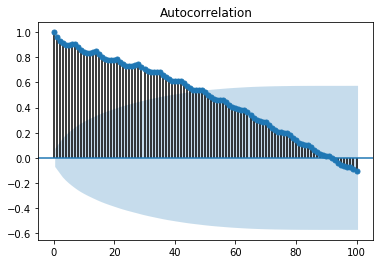

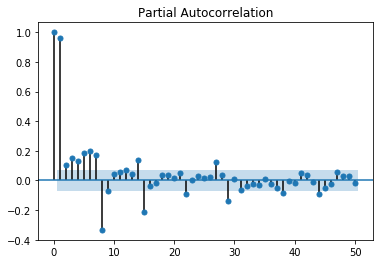

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

#correlation 100 days apart
plot_acf(train.avg_energy,lags=100)
plt.show()

plot_pacf(train.avg_energy,lags=50)
plt.show()

In [13]:
t = sm.tsa.adfuller(train.avg_energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.782500
p-value                          0.389184
#Lags Used                      14.000000
Number of Observations Used    730.000000
dtype: float64

In [14]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

t  = sm.tsa.adfuller(difference(train.avg_energy,1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])


Test Statistic                -6.482147e+00
p-value                        1.287110e-08
#Lags Used                     2.000000e+01
Number of Observations Used    7.230000e+02
dtype: float64

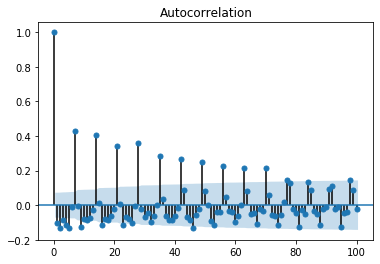

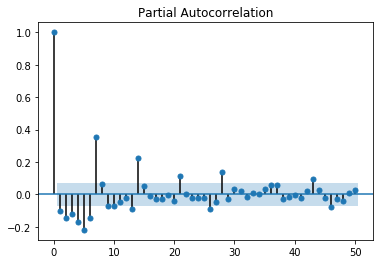

In [15]:
plot_acf(difference(train.avg_energy,1),lags=100)
plt.show()

plot_pacf(difference(train.avg_energy,1),lags=50)
plt.show()

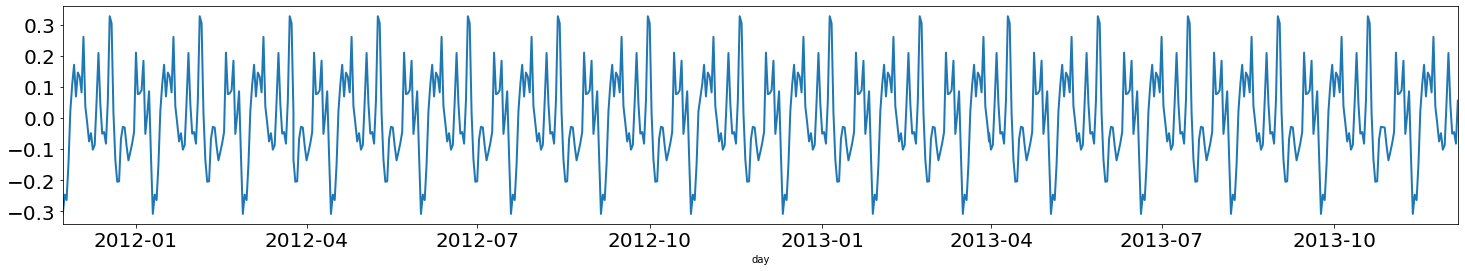

In [16]:
s = sm.tsa.seasonal_decompose(train.avg_energy, freq=48)
s.seasonal.plot(x = 'day', y = 'avg_energy',  figsize=(25,4), linewidth=2, fontsize=20)


Text(0, 0.5, 'Energy Consumption (Energy Unit)')

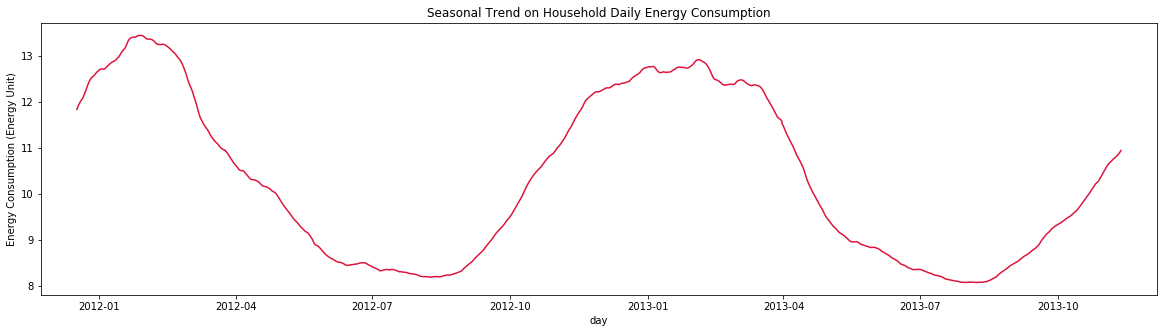

In [17]:
s.trend.plot(figsize=(20,5),c='crimson')
plt.title('Seasonal Trend on Household Daily Energy Consumption')
plt.ylabel('Energy Consumption (Energy Unit)')

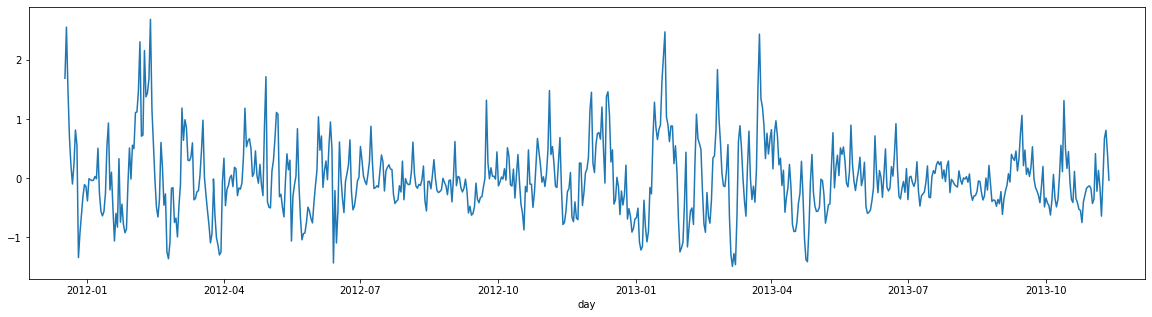

In [18]:
s.resid.plot(figsize=(20,5))

In [19]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

exog = sm.add_constant(train[['weather_cluster']])
endog = train['avg_energy']

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(4,1,0),seasonal_order=(1,1, 0, 12),trend='c')
model_fit = mod.fit()
model_fit.summary()

/Users/michellezhou/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/michellezhou/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         avg_energy   No. Observations:                  745
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -679.066
Date:                            Tue, 19 May 2020   AIC                           1376.131
Time:                                    16:24:18   BIC                           1417.493
Sample:                                         0   HQIC                          1392.087
                                            - 745                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -0.0093      0.023     -0.398      0.690      -0.055       0.037
const           -2.697e-09   4.07e+05  -6.63e-15      1.000   -7.97e+05    7.97e+05
weather_cluster    -0.0098      0.019     -0.521      0.602      -0.046       0.027
ar.L1              -0.0851      0.032     -2.636      0.008      -0.148      -0.022
ar.L2              -0.1910      0.030     -6.403      0.000      -0.250      -0.133
ar.L3              -0.2062      0.036     -5.651      0.000      -0.278      -0.135
ar.L4              -0.2563      0.032     -8.061      0.000      -0.319      -0.194
ar.S.L12           -0.5610      0.031    -17.867      0.000      -0.623      -0.499
sigma2              0.3719      0.017     22.165      0.000       0.339       0.405
===================================================================================
Ljung-Box (Q):                      594.69   Jarque-Bera (JB):                22.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.39e+14. Standard errors may be unstable.
"""

In [20]:
test['residual'] = pow((test['predicted']-test['avg_energy']),2)
RMSE = test['residual'].sum()/len(test)
print("RMSE:", RMSE)

KeyError: 'predicted'

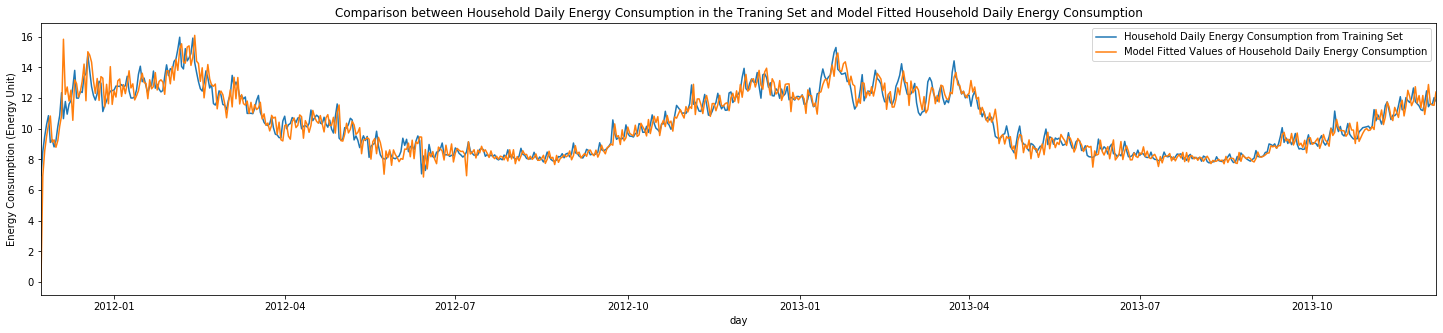

/Users/michellezhou/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/michellezhou/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/Users/michellezhou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,avg_energy,weather_cluster,predicted
day,,,
2014-02-24,10.586235,0,11.792319
2014-02-25,10.476498,0,11.372732
2014-02-26,10.375366,0,11.380010
2014-02-27,10.537250,0,11.275298
2014-02-28,0.211766,2,11.616807


In [21]:
train['avg_energy'].plot(figsize=(25,5),label='Household Daily Energy Consumption from Training Set')
model_fit.fittedvalues.plot(label='Model Fitted Values of Household Daily Energy Consumption')
plt.legend()
plt.title('Comparison between Household Daily Energy Consumption in the Traning Set and Model Fitted Household Daily Energy Consumption')
plt.ylabel('Energy Consumption (Energy Unit)')
plt.show()

predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = sm.add_constant(test[['weather_cluster']]))
test['predicted'] = predict.values
test.tail(5)


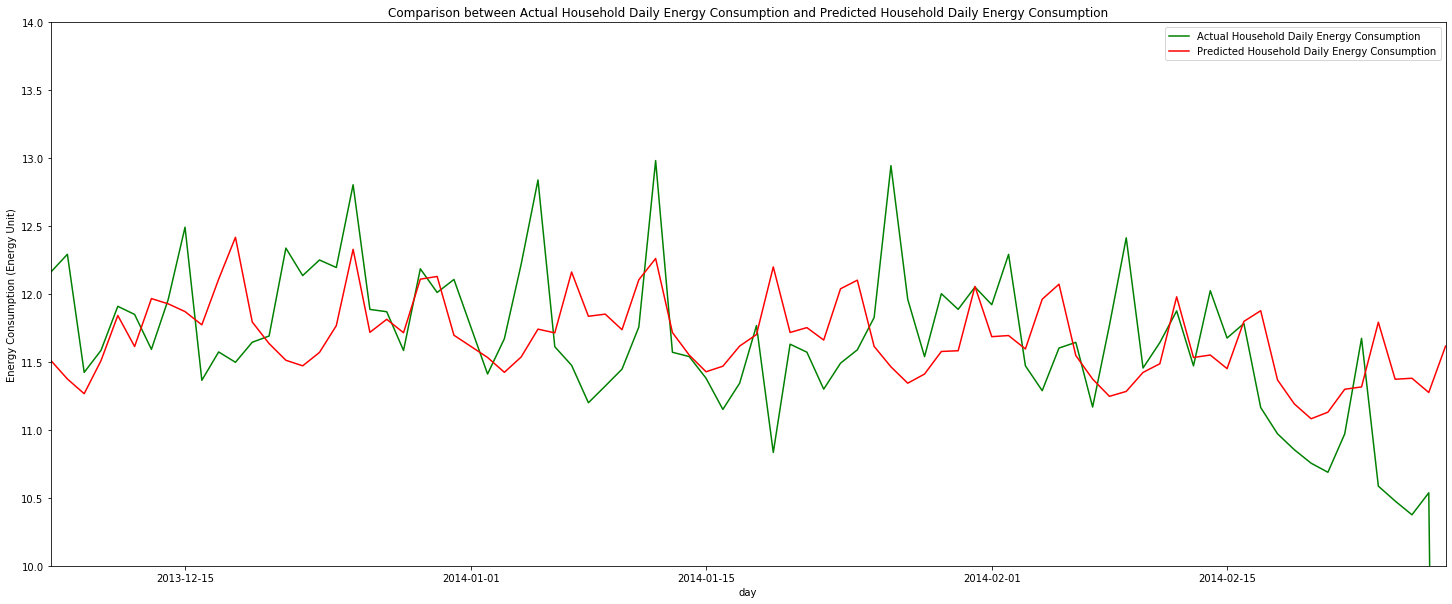

In [22]:
test['avg_energy'].plot(figsize=(25,10),color = 'green',label = 'Actual Household Daily Energy Consumption')
test['predicted'].plot(label ='Predicted Household Daily Energy Consumption',color = 'red')
plt.legend()
plt.title('Comparison between Actual Household Daily Energy Consumption and Predicted Household Daily Energy Consumption')
plt.ylabel('Energy Consumption (Energy Unit)')
plt.ylim(10,14)
plt.show()


In [23]:
test['residual'] = pow((test['predicted']-test['avg_energy']),2)
RMSE = test['residual'].sum()/len(test)
print("RMSE:", RMSE)

RMSE: 1.8433205537081232


/Users/michellezhou/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
